In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import make_pipeline
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [4]:
#path = 'C:\\Users\\david\\Desktop\\대학원\\수업\\3기 수업\\기계학습특론\\중간프로젝트'
#os.chdir(path)

df = pd.read_csv('prepro_data.csv')
df = df.dropna()
#df_raw = pd.read_csv('McDonald_Reviews.csv')

### 비율 확인

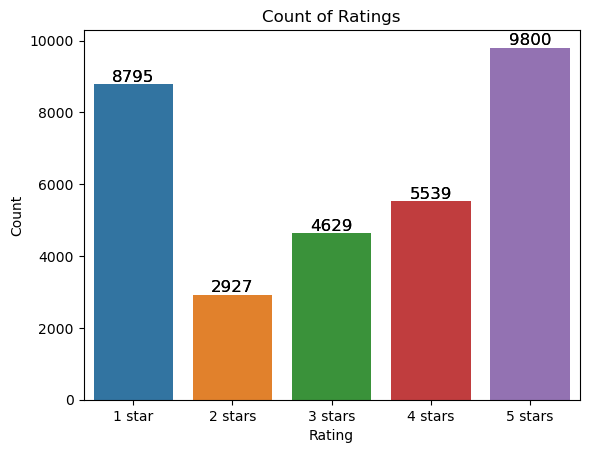

In [18]:
# 'stars'가 포함된 'rating' 값만 필터링 (NaN 값은 무시)
df_filtered = df_raw[df_raw['rating'].str.contains('star', na=False)]
order_list = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
ax = sns.countplot(x='rating', data=df_filtered, order=order_list)

sns.countplot(x='rating', data=df_filtered, order=order_list)
plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
# 각 막대에 개수 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

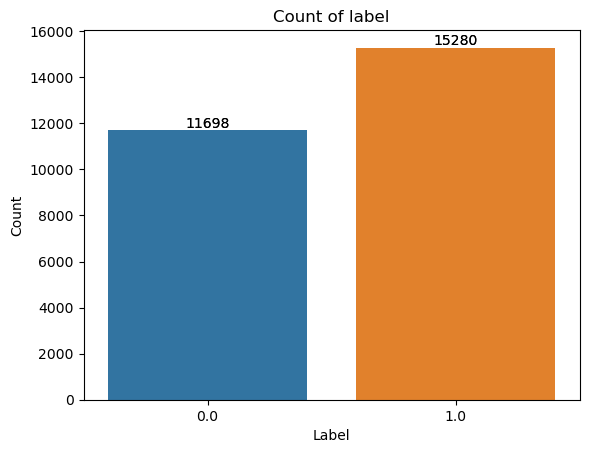

긍정 개수: 15280
부정 개수: 11698


In [20]:
sns.countplot(x='label', data=df)
ax = sns.countplot(x='label', data=df)

plt.title('Count of label')
plt.xlabel('Label')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()
print("긍정 개수:", (df["label"] == 1).sum())
print("부정 개수:", (df["label"] == 0).sum())

## Modeling

In [21]:
x = df['prepro'].copy()
y = df['label'].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify= y)

##### Bag of Words embedding

In [ ]:
bow_vectorizer = CountVectorizer(analyzer='word', max_features=3000)

# train
x_bow_train = bow_vectorizer.fit_transform(x_train)
y_train = np.array(y_train)

# test
x_bow_test = bow_vectorizer.transform(x_test)
y_test = np.array(y_test)

x_bow_train_dense = x_bow_train.toarray()
x_bow_test_dense = x_bow_test.toarray()

# GridSearchCV를 위한 함수 정의
def run_grid_search(model, params, x_train, y_train, x_test, y_test, model_name):
    grid = GridSearchCV(model, param_grid=params, cv=5, refit=True, return_train_score=True)
    grid.fit(x_train, y_train)
    
    # Best model and its predictions
    best_model = grid.best_estimator_
    pred_y_train = best_model.predict(x_train)
    pred_y_test = best_model.predict(x_test)

    # Calculate train and test accuracies
    train_accuracy = accuracy_score(y_train, pred_y_train)
    test_accuracy = accuracy_score(y_test, pred_y_test)

    # Print model results
    print(f"{model_name} train accuracy : {train_accuracy:.4f}")
    print(f"{model_name} best grid accuracy : {grid.best_score_:.4f}")
    print(f"{model_name} best parameters : {grid.best_params_}")
    print(f"{model_name} test accuracy : {test_accuracy:.4f}")

    # Save the best model
    model_path = f"C:\\Users\\dssal\\OneDrive\\바탕 화면\\충원project\\과제\\{model_name}_best_model(BoW).joblib"
    joblib.dump(best_model, model_path)
    print(f"Saved {model_name} model to {model_path}")
    
    return pred_y_test

## Modeling

# Logistic Regression
lg_params = {"max_iter": [100, 200, 300],
                "C": [0.1, 1, 10],
                "penalty": ['l1', 'l2', 'elasticnet']}
lg_model = LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)
run_grid_search(lg_model, lg_params, x_bow_train, y_train, x_bow_test, y_test, "Logistic Regression")

# GaussianNB
nb_params = {'var_smoothing': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
nb_model = GaussianNB()
run_grid_search(nb_model, nb_params, x_bow_train_dense, y_train, x_bow_test_dense, y_test, "GaussianNB")

# SVC
svc_params = {'C': [1e-1, 1, 10],
            'gamma': ['scale', 1e-3, 1e-1, 1], 
            'kernel': ['rbf']}
svc_model = SVC(class_weight='balanced', random_state=42)
run_grid_search(svc_model, svc_params, x_bow_train, y_train, x_bow_test, y_test, "SVC")

# RandomForestClassifier
rf_params = {'n_estimators': [100, 150, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 3, 5],
            'min_impurity_decrease': [0, 1e-1, 1e-2]}
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
run_grid_search(rf_model, rf_params, x_bow_train, y_train, x_bow_test, y_test, "RandomForestClassifier")

# XGBoost
xgb_params = {'gamma' : [0, 1e-1, 1e-2],
            'max_depth': [3, 4, 5], 
            'learning_rate': [0.1 ,0.3, 0.5], 
            'subsample': [0.6, 0.8, 1], 
            'colsample_bytree': [0.6, 0.8, 1]}
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1,  device ='gpu', random_state=42)
run_grid_search(xgb_model, xgb_params, x_bow_train, y_train, x_bow_test, y_test, "XGBoost")

### Word2Vec embedding

In [24]:
# Assume x_train and x_test are already provided and contain text data
x_train_li = [sentence.split() for sentence in list(x_train)]
x_test_li = [sentence.split() for sentence in list(x_test)]
model = word2vec.Word2Vec(x_train_li, vector_size=500, min_count=10, window=10)

def w2v_features(words, model, num_features):
    feature_vector = np.zeros((num_features), dtype=np.float32)
    count = 0
    index2word_set = set(model.wv.index_to_key)

    for word in words:
        if word in index2word_set:
            count += 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if count > 0:
        feature_vector = np.divide(feature_vector, count)
    return feature_vector

def get_features(reviews, model, num_features):
    dataset = [w2v_features(sentence, model, num_features) for sentence in reviews]
    review_features_vecs = np.vstack(dataset)
    return review_features_vecs

x_w2v_train = get_features(x_train_li, model, num_features=500)
x_w2v_test = get_features(x_test_li, model, num_features=500)
y_train = np.array(y_train)
y_test = np.array(y_test)

def run_grid_search_word2vec(model, params, x_train, y_train, x_test, y_test, model_name):
    grid = GridSearchCV(model, param_grid=params, cv=5, refit=True, return_train_score=True)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    pred_y_train = best_model.predict(x_train)
    pred_y_test = best_model.predict(x_test)
    train_accuracy = accuracy_score(y_train, pred_y_train)
    test_accuracy = accuracy_score(y_test, pred_y_test)

    print(f"{model_name} train score: {train_accuracy:.4f}")
    print(f"{model_name} best grid score: {grid.best_score_:.4f}")
    print(f"{model_name} best parameters : {grid.best_params_}")
    print(f"{model_name} test accuracy : {test_accuracy:.4f}")

    model_path = f"{model_name}_best_model(Word2Vec).joblib"
    joblib.dump(best_model, model_path)
    print(f"Saved {model_name} model to {model_path}")
    return pred_y_test

# Model parameters setup
lg_params = {"max_iter": [100, 200, 300], "C": [0.1, 1, 10], "penalty": ['l2']}
lg_model = LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)
run_grid_search_word2vec(lg_model, lg_params, x_w2v_train, y_train, x_w2v_test, y_test, "Logistic Regression")

nb_model = GaussianNB()
nb_params = {'var_smoothing': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
run_grid_search_word2vec(nb_model, nb_params, x_w2v_train, y_train, x_w2v_test, y_test, "GaussianNB")

svc_params = {'C': [1e-1, 1, 10], 'gamma': ['scale', 1e-3, 1e-1, 1], 'kernel': ['rbf']}
svc_model = SVC(class_weight='balanced', random_state=42)
run_grid_search_word2vec(svc_model, svc_params, x_w2v_train, y_train, x_w2v_test, y_test, "SVC")

rf_params = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 3, 5], 'min_impurity_decrease': [0, 1e-1, 1e-2]}
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
run_grid_search_word2vec(rf_model, rf_params, x_w2v_train, y_train, x_w2v_test, y_test, "RandomForestClassifier")

xgb_params = {'gamma': [0, 1e-1, 1e-2], 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.3, 0.5], 'subsample': [0.6, 0.8, 1], 'colsample_bytree': [0.6, 0.8, 1]}
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, random_state=42)
run_grid_search_word2vec(xgb_model, xgb_params, x_w2v_train, y_train, x_w2v_test, y_test, "XGBoost")

Logistic Regression train score: 0.8760
Logistic Regression best grid score: 0.8741
Logistic Regression best parameters : {'C': 10, 'max_iter': 200, 'penalty': 'l2'}
Logistic Regression test accuracy : 0.8838
Saved Logistic Regression model to Logistic Regression_best_model(Word2Vec).joblib
GaussianNB train score: 0.8204
GaussianNB best grid score: 0.8201
GaussianNB best parameters : {'var_smoothing': 0.001}
GaussianNB test accuracy : 0.8215
Saved GaussianNB model to GaussianNB_best_model(Word2Vec).joblib
SVC train score: 0.9346
SVC best grid score: 0.8792
SVC best parameters : {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC test accuracy : 0.8879
Saved SVC model to SVC_best_model(Word2Vec).joblib
RandomForestClassifier train score: 0.9894
RandomForestClassifier best grid score: 0.8987
RandomForestClassifier best parameters : {'max_depth': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
RandomForestClassifier test accuracy : 0.9049
Saved

array([1, 1, 1, ..., 0, 1, 0])

##### TF-IDF embedding

In [25]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.0, analyzer='word', ngram_range=(1,3), max_features=3000)

x_tfidf_train = tfidf_vectorizer.fit_transform(x_train)
x_tfidf_test = tfidf_vectorizer.transform(x_test)

x_tfidf_train_dense = x_tfidf_train.toarray()
x_tfidf_test_dense = x_tfidf_test.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

def grid_search_tfidf(model, params, x_train, y_train, x_test, y_test, model_name):
    grid = GridSearchCV(model, param_grid=params, cv=5, refit=True, return_train_score=True)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    pred_y_train = best_model.predict(x_train)
    pred_y_test = best_model.predict(x_test)
    train_accuracy = accuracy_score(y_train, pred_y_train)
    test_accuracy = accuracy_score(y_test, pred_y_test)

    print(f"{model_name} train accuracy : {train_accuracy:.4f}")
    print(f"{model_name} best grid accuracy : {grid.best_score_:.4f}")
    print(f"{model_name} best parameters : {grid.best_params_}")
    print(f"{model_name} test accuracy : {test_accuracy:.4f}")

    model_path = f"{model_name}_best_model(TF-IDF).joblib"
    joblib.dump(best_model, model_path)
    print(f"Saved {model_name} model to {model_path}")

    return pred_y_test

## Modeling

# Logistic Regression
lg_params = {"max_iter": [100, 200, 300], "C": [0.1, 1, 10], "penalty": ['l2']} 
lg_model = LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42)
grid_search_tfidf(lg_model, lg_params, x_tfidf_train, y_train, x_tfidf_test, y_test, "Logistic Regression")

# GaussianNB
nb_params = {'var_smoothing': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
nb_model = GaussianNB()
grid_search_tfidf(nb_model, nb_params, x_tfidf_train_dense, y_train, x_tfidf_test_dense, y_test, "GaussianNB")

# SVC
svc_params = {'C': [1e-1, 1, 10], 'gamma': ['scale', 1e-3, 1e-1, 1], 'kernel': ['rbf']}
svc_model = SVC(class_weight='balanced', random_state=42)
grid_search_tfidf(svc_model, svc_params, x_tfidf_train, y_train, x_tfidf_test, y_test, "SVC")

# RandomForestClassifier
rf_params = {'n_estimators': [100, 150, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 3, 5], 'min_impurity_decrease': [0, 1e-1, 1e-2]}
rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
grid_search_tfidf(rf_model, rf_params, x_tfidf_train, y_train, x_tfidf_test, y_test, "RandomForestClassifier")

# XGBoost
xgb_params = {'gamma': [0, 1e-1, 1e-2], 'max_depth': [3, 4, 5], 'learning_rate': [0.1, 0.3, 0.5], 'subsample': [0.6, 0.8, 1], 'colsample_bytree': [0.6, 0.8, 1]}
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, device='gpu', random_state=42)
grid_search_tfidf(xgb_model, xgb_params, x_tfidf_train, y_train, x_tfidf_test, y_test, "XGBoost")

Logistic Regression train accuracy : 0.9481
Logistic Regression best grid accuracy : 0.9114
Logistic Regression best parameters : {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Logistic Regression test accuracy : 0.9073
Saved Logistic Regression model to Logistic Regression_best_model(TF-IDF).joblib
GaussianNB train accuracy : 0.9111
GaussianNB best grid accuracy : 0.8889
GaussianNB best parameters : {'var_smoothing': 0.001}
GaussianNB test accuracy : 0.8875
Saved GaussianNB model to GaussianNB_best_model(TF-IDF).joblib
SVC train accuracy : 0.9888
SVC best grid accuracy : 0.9246
SVC best parameters : {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVC test accuracy : 0.9236
Saved SVC model to SVC_best_model(TF-IDF).joblib
RandomForestClassifier train accuracy : 0.9883
RandomForestClassifier best grid accuracy : 0.9133
RandomForestClassifier best parameters : {'max_depth': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
RandomForestClassif

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
import matplotlib.pyplot as plt

# Dummy accuracy results for demonstration purposes (usually you would get these from the actual model runs)
#model_accuracies = {
    "Logistic Regression": 0.9083,
    "GaussianNB": 0.7559,
    "SVC": 0.9148,
    "RandomForest": 0.9158,
    "XGBoost": 0.9062
}

# Plotting the accuracies as a bar chart
plt.figure(figsize=(8, 4))
colors = ['brown', 'green', 'magenta', 'blue', 'orange']
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('BoW Model Accuracy')
plt.ylim(0.7, 1)  # Adjust y-axis limits to better visualize the differences
plt.show()
